US Accident Analysis and Insights
    The datasets for this project are obtained from the kaggle. It contains the countrywide car accident datasets collected from various entities.

First let's import the necessary libraries and modules for the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
%matplotlib inline
from matplotlib.colors import rgb2hex
from plotly import graph_objs as go

from matplotlib.colors import ListedColormap
import contextily as ctx

import geopandas as gpd
import geoplot
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the dataset into panda library
df = pd.read_csv(r"D:\Python\Learning Python\accident_analysis\sampled_data.csv")

In [3]:
# convert the Start_Time & End_Time Variable into Datetime Feature
df.Start_Time = pd.to_datetime(df.Start_Time, errors = 'coerce')
df.End_Time = pd.to_datetime(df.End_Time, errors = 'coerce')

In [4]:
# create a dataframe of city and their corresponding accident cases
city_df = pd.DataFrame(df['City'].value_counts()).reset_index().rename(columns={'index':'City', 'count':'Cases'})

In [5]:
top_10_cities = pd.DataFrame(city_df.head(10))
print(top_10_cities)

          City  Cases
0        Miami   4991
1      Houston   4588
2  Los Angeles   4332
3    Charlotte   3633
4       Dallas   3552
5      Orlando   2830
6       Austin   2647
7      Raleigh   2307
8    Nashville   1962
9  Baton Rouge   1874


In [7]:
# Load US states data
states = gpd.read_file(r'D:\Python\Learning Python\accident_analysis\Kaggle\us-states.json')

# Function to get latitude and longitude for a city
def get_coordinates(city):
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(city)
    if location:
        return location.latitude, location.longitude
    return None, None

# List of top 10 cities
top_ten_cities = city_df.City.head(10)

# Dictionary to store latitudes and longitudes
coordinates = {city: get_coordinates(city) for city in top_ten_cities}

# Add latitude and longitude to the original DataFrame
top_10_cities_df = df[df['City'].isin(top_ten_cities)].copy()
top_10_cities_df['New_Start_Lat'] = top_10_cities_df['City'].map(lambda x: coordinates[x][0])
top_10_cities_df['New_Start_Lng'] = top_10_cities_df['City'].map(lambda x: coordinates[x][1])


In [8]:
geometry_cities = [Point(xy) for xy in zip(top_10_cities_df['New_Start_Lng'], top_10_cities_df['New_Start_Lat'])]
geo_df_cities = gpd.GeoDataFrame(top_10_cities_df, geometry=geometry_cities)

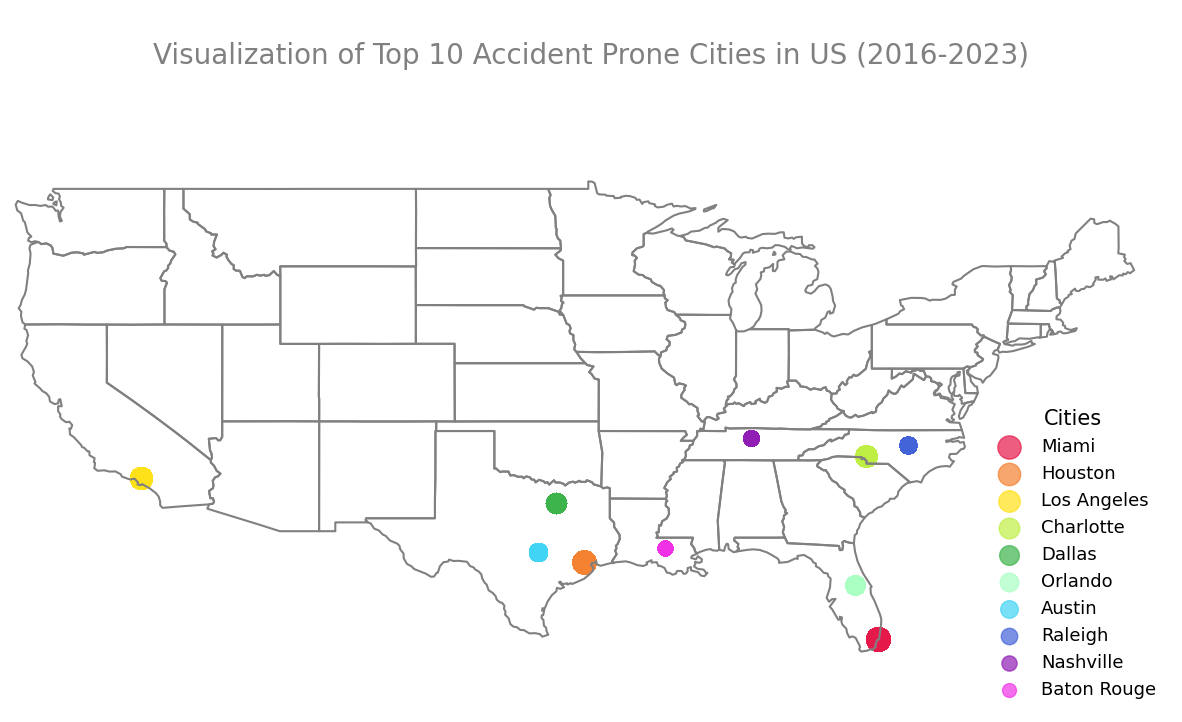

In [9]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim([-125, -65])
ax.set_ylim([22, 55])
states.boundary.plot(ax=ax, color='grey')

# Define colors and marker sizes for the top 10 cities
colors = ['#e6194B', '#f58231', '#ffe119', '#bfef45', '#3cb44b', 
          '#aaffc3', '#42d4f4', '#4363d8', '#911eb4', '#f032e6']
markersizes = [100 + (i * 20) for i in range(10)][::-1]

# Plot each city with its corresponding color and marker size
for i, city in enumerate(top_ten_cities):
    geo_df_cities[geo_df_cities['City'] == city].plot(
        ax=ax,
        markersize=markersizes[i],
        color=colors[i],
        marker='o',
        label=city,
        alpha=0.7
    )

# Add legend with custom properties
plt.legend(
    prop={'size': 13},
    loc='best',
    bbox_to_anchor=(0.5, 0., 0.5, 0.5),
    edgecolor='white',
    title="Cities",
    title_fontsize=15
)

# Hide spines
for spine in ['bottom', 'top', 'left', 'right']:
    ax.spines[spine].set_visible(False)

# Remove ticks and labels
plt.tick_params(
    top=False, bottom=False, left=False, right=False,
    labelleft=False, labelbottom=False
)

# Add title
plt.title(
    '\nVisualization of Top 10 Accident Prone Cities in US (2016-2023)',
    size=20, color='grey'
)

# Show the plot
plt.show()


In [10]:
def city_cases_percentage(threshold, operator):
    """
    Calculate and print the percentage of cities in the US based on a case threshold and operator.
    
    Parameters:
    - threshold (int): The case value to compare against.
    - operator (str): The comparison operator ('<', '>', '=').
    
    Output:
    Prints a formatted message with the percentage of cities and the condition.
    """
    if operator not in ['<', '>', '=']:
        print("Invalid operator. Please use '<', '>', or '='.")
        return
    
    # Filter cities based on the operator
    if operator == '<':
        matching_cities = city_df[city_df['Cases'] < threshold]
        condition = f"less than {threshold}"
    elif operator == '>':
        matching_cities = city_df[city_df['Cases'] > threshold]
        condition = f"greater than {threshold}"
    elif operator == '=':
        matching_cities = city_df[city_df['Cases'] == threshold]
        condition = f"equal to {threshold}"
    
    # Calculate results
    count = matching_cities.shape[0]
    total_cities = city_df.shape[0]
    percentage = round((count / total_cities) * 100, 2)
    
    # Print results
    print(f"{percentage}% of cities in the US have accidents {condition}.")

# Example usage
city_cases_percentage(1, '=')
city_cases_percentage(100, '<')
city_cases_percentage(1000, '<')
city_cases_percentage(1000, '>')
city_cases_percentage(5000, '>')



24.42% of cities in the US have accidents equal to 1.
95.8% of cities in the US have accidents less than 100.
99.69% of cities in the US have accidents less than 1000.
0.31% of cities in the US have accidents greater than 1000.
0.0% of cities in the US have accidents greater than 5000.


In [11]:
timezone_df = pd.DataFrame(df['Timezone'].value_counts()).reset_index().rename(columns={'index':'Timezone', 'count':'Cases'})
print(timezone_df)

      Timezone  Cases
0   US/Eastern  96952
1   US/Pacific  56374
2   US/Central  44467
3  US/Mountain  11718


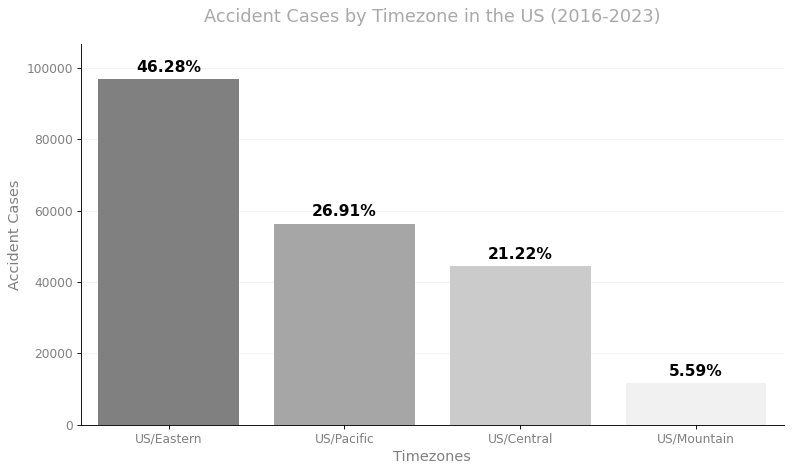

In [12]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

# Plot the barplot with a monochromatic palette
sns.barplot(
    x=timezone_df['Timezone'], 
    y=timezone_df['Cases'], 
    palette=sns.light_palette("gray", reverse=True, n_colors=len(timezone_df)), 
    ax=ax
)

# Total number of cases
total = timezone_df['Cases'].sum()

# Add percentage labels on the bars
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 2000,  # Slightly above the bars
        f"{round(bar.get_height() * 100 / total, 2)}%", 
        ha='center', fontsize=14, weight = 'bold', color='black'
    )

# Set plot limits
plt.ylim(0, timezone_df['Cases'].max() * 1.1)  # Dynamic y-axis scaling

# Title and labels
plt.title(
    'Accident Cases by Timezone in the US (2016-2023)', 
    fontsize=16, color='darkgray', pad=20
)
plt.ylabel('Accident Cases', fontsize=13, color='gray')
plt.xlabel('Timezones', fontsize=13, color='gray')

# Adjust tick labels
plt.xticks(fontsize=11, color='gray')
plt.yticks(fontsize=11, color='gray')

# Remove top and right spines for a cleaner look
for side in ['top', 'right']:
    ax.spines[side].set_visible(False)

# Add subtle grid lines for clarity
ax.set_axisbelow(True)
ax.grid(color='lightgray', linewidth=0.7, axis='y', alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()


In [13]:
timezone_df = pd.DataFrame(df['Timezone'].value_counts()).reset_index().rename(columns={'Cases':'Timezone', 'count':'Cases'})
print(timezone_df)

      Timezone  Cases
0   US/Eastern  96952
1   US/Pacific  56374
2   US/Central  44467
3  US/Mountain  11718


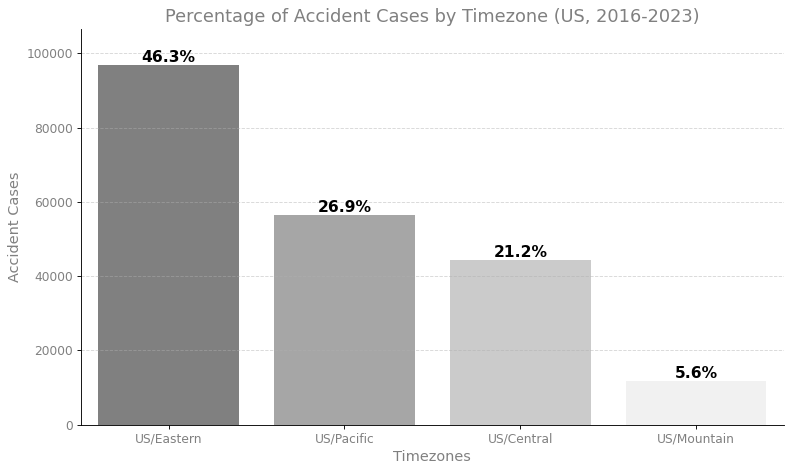

In [14]:
# Plot configuration
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

# Barplot with shades of a single color (e.g., grayscale)
sns.barplot(
    y=timezone_df['Cases'], 
    x=timezone_df['Timezone'], 
    palette=sns.light_palette("gray", reverse=True, n_colors=len(timezone_df)), 
    ax=ax
)

# Adding percentage labels on bars
total = timezone_df['Cases'].sum()  # Total cases for percentage calculation
for bar in ax.patches:
    percentage = round(bar.get_height() * 100 / total, 1)
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() +5000 - total * 0.02,  # Slightly above bar base
        f"{percentage}%", 
        ha='center', fontsize=14, color='black', weight='bold'
    )

# Titles and labels
ax.set_title(
    'Percentage of Accident Cases by Timezone (US, 2016-2023)', 
    fontsize=16, color='grey'
)
ax.set_ylabel('Accident Cases', fontsize=13, color='grey')
ax.set_xlabel('Timezones', fontsize=13, color='grey')

# Aesthetic adjustments
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, timezone_df['Cases'].max() * 1.1)  # Dynamic y-axis scaling
plt.xticks(fontsize=11, color='grey')
plt.yticks(fontsize=11, color='grey')

# Final adjustments for cleaner look
plt.tight_layout()
plt.show()


In [15]:
# create a dataframe of Severity and the corresponding accident cases
severity_df = pd.DataFrame(df['Severity'].value_counts()).rename(columns={'index':'Severity', 'count':'Cases'})
print(severity_df)

           Cases
Severity        
2         167024
3          35426
4           5413
1           1852


In [16]:
from plotly.graph_objs import Funnelarea

fig = go.Figure(go.Funnelarea(
    text=["Severity - 2", "Severity - 3", "Severity - 4", "Severity - 1"],  # Labels
    values=severity_df.Cases,  # Corresponding values
    title={
        "position": "top center", 
        "text": "<b>Traffic Impact from Accidents</b>", 
        "font": dict(size=16, color="#4d4d4d")  # Smaller, neutral font
    },
    marker={
        "colors": ["#4a90e2", "#50e3c2", "#f5a623", "#d0021b"],  # Minimal color palette
        "line": {"color": "#ffffff", "width": 0}  # No borders for simplicity
    }
))

# Show the figure
fig.show()

In [17]:
accident_duration_df = pd.DataFrame(df['End_Time'] - df['Start_Time']).reset_index().rename(columns={'index':'Id', 0:'Duration'})
print(accident_duration_df)

            Id        Duration
0            0             NaT
1            1 0 days 01:15:00
2            2 0 days 06:00:00
3            3 0 days 00:41:00
4            4 0 days 04:00:00
...        ...             ...
209710  209710 0 days 00:29:00
209711  209711 0 days 01:00:00
209712  209712 0 days 01:45:00
209713  209713 0 days 00:29:00
209714  209714 0 days 01:00:00

[209715 rows x 2 columns]


In [18]:
top_10_accident_duration_df = (
    pd.DataFrame(accident_duration_df['Duration'].value_counts().head(10).sample(frac=1))
    .reset_index()
    .rename(columns={'Cases': 'Duration', 'count': 'Cases'})
)
print(top_10_accident_duration_df)

Duration = [str(i).split('days')[-1].strip() for i in top_10_accident_duration_df.Duration]

top_10_accident_duration_df['Duration'] = Duration


         Duration  Cases
0 0 days 06:00:00  10078
1 0 days 00:44:00   6089
2 0 days 01:17:00   2699
3 0 days 00:45:00  11254
4 0 days 01:18:00   3158
5 0 days 00:29:00  16013
6 0 days 01:00:00   7917
7 0 days 00:59:00   3981
8 0 days 01:15:00   5959
9 0 days 00:30:00  25262


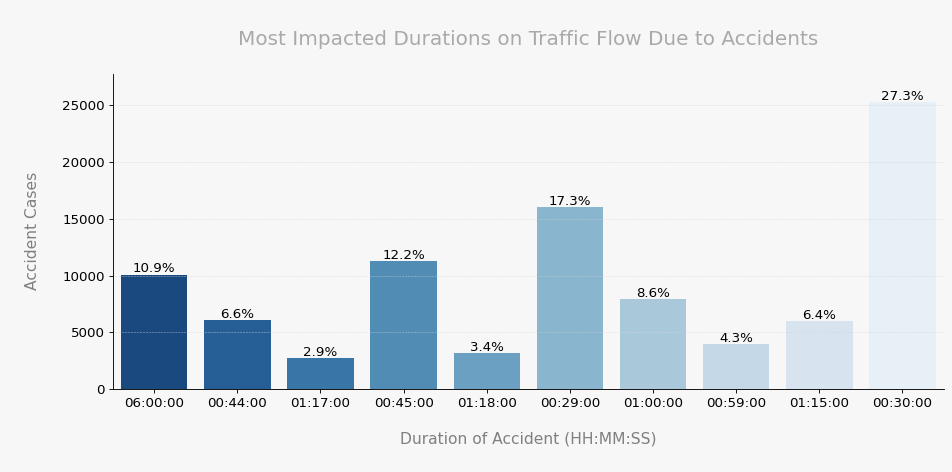

In [19]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), dpi=80)
ax.set_facecolor('#f7f7f7')  # Light background for better readability
fig.patch.set_facecolor('#f7f7f7')

# Create the barplot
sns.barplot(
    y=top_10_accident_duration_df['Cases'], 
    x=top_10_accident_duration_df['Duration'], 
    palette='Blues_r', 
    ax=ax
)

# Add total case percentage on the bars
total = top_10_accident_duration_df['Cases'].sum()
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # Center the label
        bar.get_height() + 500,            # Slightly above the bar
        f"{bar.get_height() / total * 100:.1f}%",  # Format as a percentage
        ha='center', va='center', fontsize=12, color='black'
    )

# Title and labels
ax.set_title(
    '\nMost Impacted Durations on Traffic Flow Due to Accidents\n', 
    fontsize=18, color='darkgray'
)
ax.set_xlabel('\nDuration of Accident (HH:MM:SS)\n', fontsize=14, color='gray')
ax.set_ylabel('\nAccident Cases\n', fontsize=14, color='gray')

# Customize tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust the y-axis limit
ax.set_ylim(0, top_10_accident_duration_df['Cases'].max() * 1.1)

# Remove unnecessary spines for a cleaner look
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Add gridlines for clarity
ax.grid(color='lightgray', linestyle='--', linewidth=0.5, axis='y', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
